## Import lib

In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import os
import re
from collections import Counter
from rapidfuzz import process, fuzz

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from sklearn.feature_extraction.text import TfidfVectorizer
from underthesea import word_tokenize, pos_tag, chunk, dependency_parse

from sklearn.metrics import confusion_matrix
import cv2
import requests
import openpyxl
import xlsxwriter

from TexSoup import TexSoup

from tqdm.autonotebook import tqdm
from typing import (
    Callable,
    Hashable,
    Sequence
)

def ShowImage(ImageList, NameList=None, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    from matplotlib import pyplot as plt 
    import matplotlib.gridspec as gridspec
    
    gs = gridspec.GridSpec(nRows, nCols)     
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(40,40))
    # plt.rcParams["figure.figsize"] = [16,9]
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        plt.subplot(nRows, nCols,i+1)

        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)

        if NameList == None:
            plt.title("Image " + str(i))
        else:
            plt.title(NameList[i])
        plt.axis('off')

    plt.show()

pd.options.plotting.backend = "plotly"
pd.set_option('display.max_colwidth', None)

/var/folders/2z/c11mbd_x6dn12d_ykf68p7gr0000gn/T/ipykernel_909/4095199142.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Import dataset

In [2]:
if os.name == "nt":
    data_path = r"G:\My Drive\Work\ICM - GE\1. Dataset\2k_sample\2k_data_Sep.csv"

else:
    data_path = '/Users/admin/Library/CloudStorage/GoogleDrive-huypnm@galaxy.com.vn/My Drive/Work/ICM - GE/1. Dataset/2k_sample/2k_data_Sep.csv'

data = pd.read_csv(data_path)

In [3]:
if os.name == 'nt':
    image_path = r"G:\My Drive\Work\ICM - GE\1. Dataset\temp_images"
else:
    image_path = '/Users/admin/Library/CloudStorage/GoogleDrive-huypnm@galaxy.com.vn/My Drive/Work/ICM - GE/1. Dataset/temp_images'

## Implement important function for EDA

In [4]:
def handle_formula(t:str):
    """
        Function that split a text that contain both text and formula(in Latex form)

        Args:
            t (str): a string type input

        Returns:
            t (str): a string contain only text
            formulas (list): a list contain all possible formula 
    """
    s = t
    text_string = t
    formulas = []
    # math_operators =["+", "-", "*", "/", "=", "<", ">"]
    begin = s.find("\(") if s.find("\(") != -1 else s.find("\[")
    math_expression_bracket = [
        ["\(", "\)"],
        ["\[", "\]"]
    ]
    for bracket in math_expression_bracket:
        temp_s = s 
        begin = temp_s.find(bracket[0])

        while begin != - 1:
            begin, end = temp_s.find(bracket[0]), temp_s.find(bracket[1])
            formula = temp_s[begin:end + 2]
            if begin != -1:
                formulas.append(formula)

            temp_s = temp_s[end+2:]

    for math_expression in formulas:
        text_string = "".join(text_string.split(math_expression))

    return text_string, formulas

# ===================================================================
def clean_string_v1(t:str, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    table = str.maketrans(filters, len(filters)*" ")
    t = t.translate(table)
    t = re.sub(r'\d+', '', t) # Remove number
    return word_tokenize(t.lower(), format='text')

# ===================================================================
def to_raw_string(s:str):
    """
        Return a raw string
    """
    escape_dict={
       '\a':r'\a',
       '\b':r'\b',

    #    '\r':r'\r',
    #    '\n':r'\n',
    #    '\t':r'\t',

       '\f':r'\f',
       '\v':r'\v',
       '\'':r'\'',
       '\"':r'\"','\0':r'\0','\1':r'\1','\2':r'\2','\3':r'\3','\4':r'\4','\5':r'\5','\6':r'\6','\7':r'\7','\8':r'\8','\9':r'\9'
        }
    raw_s = ''
    for char in s:
        try: raw_s += escape_dict[char]
        except KeyError: raw_s += char
    return raw_s

# ===================================================================
def strip_latex(t:str):
    sequence_text = TexSoup(t).text
    return " ".join(sequence_text)

# ===================================================================
def apply_filter(t:str, filter=r"(?ui)\W"):
    """
        Apply filter to keep number and character
    """
    r = re.compile(filter)
    str_out = r.sub(" ", t)
    return str_out

# ===================================================================
def create_phrase(t:str):
    return word_tokenize(t, format='text')

# ===================================================================
def sequence_of_text(s:str, opt=[0,1,2,3]):
    """
        Clean string, return string only contain text
    """
    clean_option = {
        0:to_raw_string, # Convert string to raw string to keep some escape character
        1:strip_latex, # Strip latex symbol
        2:apply_filter, # Apply filter keep number and char
        3:create_phrase # Create phrase using 'underthesea'
    }
    str_out, _ = handle_formula(s) # Extract text part
    for option in opt:
        str_out = clean_option[option](str_out)
    return " ".join(str_out.split()).lower() # Remove duplicate space

# ===================================================================
def sequence_of_formula(s:str):
    """
        Clean string, return sequence of 
    """
    _, formulas = handle_formula(s)
    formula_out = []
    for formula in formulas: # Loop over single formula
        r_formula = to_raw_string(formula)
        fixed_formula = handle_formula_exception(r_formula) # Fix some exception error when using TexSoup (doesn't cover all cases)
        try:
            non_latex_formula = strip_latex(fixed_formula) # Try strip latex symbol
        except TypeError:
            non_latex_formula = clean_math_symbol(fixed_formula) # If fail, striping simple character '()[\]{|}'
        formula_out.append(
            " ".join(non_latex_formula.split()).lower() # Remove duplicate space
        )
    return formula_out

# ===================================================================
def clean_math_symbol(formula:str, filters='()[\]{|}'):
    table = str.maketrans(filters, len(filters)*" ")
    formula = formula.translate(table)
    return formula

# ===================================================================
def handle_formula_exception(formula:str):
    """
        Handle special case before stripping latex symbol
    """
    cases = [
        'left(', 
        'right)'
        ]
    formula_split = formula.split()
    result_split = []

    for element in formula_split:
        if any(case in element for case in cases):
            for case in cases:
                running_ele = element
                possible_idx = []
                idx_find = running_ele.find(case)
                while idx_find != -1:
                    idx_find = running_ele.find(case)
                    if idx_find != -1:
                        possible_idx.append(idx_find)
                    running_ele = running_ele[idx_find + len(case):]

                element = ''.join(
                    [
                        element[:idx + len(case)] + " " + element[idx + len(case):] for idx in possible_idx
                    ]) if len(possible_idx) != 0 else element
                    
        result_split.append(element)
    return ' '.join(result_split)

# ===================================================================
def preprocess_text(s:str):
    """
        Retrieve text from entire string contain both formula
    """
    text, _ = handle_formula(s)
    text = clean_string_v1(text)
    return text
    
# ===================================================================
def preprocess_formula(s:str):
    """
        Retrieve formula from entire string contain both formula and text 
    """
    _, formulas = handle_formula(s)
    return formulas

# ===================================================================
def calculate_ratio(s:str, processor_opt:str='new', opt:str='text'):
    """
        Return ratio between text and math expression
    """
    if processor_opt == 'new':
        text_measure = sequence_of_text(s)
        formulas = sequence_of_formula(s)

    else:
        text, formulas = handle_formula(s)

        text_measure = clean_string_v1(text)

    formula_measure = " ".join(formulas)

    if opt == 'text':
        return len(text_measure) / (len(text_measure) + len(formula_measure) + 10e-9) # Prevent division by zero error

    else:
        return len(formula_measure) / (len(text_measure) + len(formula_measure) + 10e-9) # Prevent division by zero error 

# ===================================================================
def text_analyze_v2(s:str, idx, word_dict, processor_opt:str='new'):
    """
        Analyze string text and return it's case

        Args:
            s (str): a string type text
        Returns
            A string type indicate which kind the text belong to
            "Math only"
            "Text only"
            "Math and Text"
    """
    if processor_opt == 'new':
        try:
            text_strings = sequence_of_text(s)
            formulas = sequence_of_formula(s)
        except TypeError:
            print("Check Feedback ID {}".format(idx))
    else:
        text, formulas = handle_formula(s)
        text_strings = clean_string_v1(text)
    # formula_strings = " ".join(formulas)
    # This will take 'Text only' case
    math_operators =["+", "-", "*", "/", "=", "<", ">", "^"]
    check_operator = []
    for formula in formulas:
        check_operator.append(any([operator in formula for operator in math_operators]))

    not_math_expression = check_operator.count(True) < (len(formulas) / 2)

    token_words = text_to_sequence(s, word_dict)
    # This will take "Math only" case
    if (
        # When string is empty
        str.isspace(text_strings) or 
        # When formulas length outnumber text length
        len(token_words) < len(formulas) * 2 or 
        # When only 1 type of token exist
        len(token_words) <= 5):
        return 'Math only'

    if len(formulas) == 0 or not_math_expression:
        return "Text only"

    return "Math and Text"

# ===================================================================
def text_analyze_v1(s:str, word_dict:dict):
    """
        Analyze string text and return it's case

        Args:
            s (str): a string type text
        Returns
            A string type indicate which kind the text belong to
            "Math only"
            "Text only"
            "Math and Text"
    """
    text, formulas = handle_formula(s)
    text_measure = clean_string_v1(text)
    formula_measure = " ".join(formulas)
    # This will take 'Text only' case
    if len(formulas) == 0:
        return "Text only"

    token_words = text_to_sequence(s, word_dict)
    # This will take "Math only" case
    if (
        # When string is empty
        str.isspace(text_measure) or 
        # When number of formula outnumber number of token
        len(token_words) < len(formulas) or
        # When only 1 type of token exist
        len(set(token_words)) <= 1):
        return 'Math only'

    return "Math and Text"

# ===================================================================
def create_dict(df, normalization:bool=True):
    """
        Create dictionary of words from corpus

        Args:
            corpus (list): list contain Latex strings
            normalization (bool) : if True will using tf-idf weighted to normalize dictionary 
        Returns:
            a dictionary type contain all token words
    """
    vocab_corpus = []
    for _, row in df.iterrows():
        try:
            lookup_token = tokenize(row['Lookup Text'])
            question_token = tokenize(row['Question Text'])
            vocab_corpus.extend(lookup_token)
            vocab_corpus.extend(question_token)
        except:
            print("Check Feedback ID {}".format(row['Feedback ID']))

    vocab_corpus = sorted(set(vocab_corpus))
    dict_vocab = {j: i for i, j in enumerate(vocab_corpus, start=0)}

    if normalization:
        norm_vectorize = dict_normalization(df, vocab_corpus)
        for index, key in enumerate(dict_vocab):
            dict_vocab[key] = norm_vectorize[index]

    return dict_vocab

# ===================================================================
def dict_normalization(df:pd.DataFrame, word_dict:dict):
    """ 
        Return a dictionary normalized by Tf-Idf
    """
    corpus = df['Lookup Text'].tolist() + df['Question Text'].tolist()
    corpus = [sequence_of_text(sentence) for sentence in corpus]
    
    vectorizer = TfidfVectorizer(analyzer='word', min_df=0, vocabulary=word_dict).fit(corpus)
    # norm_values = vectorizer.toarray().std(axis=0)
    # return {i:j for i, j in zip(word_dict, norm_values)}
    return vectorizer.idf_


# ===================================================================
def tokenize(s:str, processor_opt:str='new',filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    """
        Tokenize a string into a list of string

        Args:
            s (str): Latex string
            filters (str): String stopword

        Returns:
            list : contain all string words (exclude math expression) being splitted from the original text
    """
    if processor_opt == 'new':
        t = sequence_of_text(s)
        sequence_out = t.split()

    else:
        t = preprocess_text(s)
        sequence_out = clean_string_v1(t, filters).split()

    return sequence_out

# ===================================================================
def text_to_sequence(t:str, word_dict:dict | None=None, processor_opt='new'):
    """
        Convert string of words into list of index from dictionary

        Args:
            t (str): string of words
            word_dict (dict): dictionary of words

        Returns:
            list of index words in original string
    """
    # After cleaned, split into char level
    token_words = tokenize(t, processor_opt)
    token_words = [token for token in token_words if len(token) > 1]

    if word_dict != None:
        sequence = list(map(lambda x: word_dict.get(x, -1), token_words))

    else:
        sequence = token_words

    return sequence

In [5]:
def dominated_depedency_parsing(s, searching_parsing='compound'):
    cleaned_text = sequence_of_text(s)
    if len(cleaned_text) == 0 or str.isspace(cleaned_text):
        return 'Not contain text'
    list_entity = dependency_parse(cleaned_text)

    unique_entity = np.array(np.unique(np.array(list_entity)[:,2], return_counts=True)).transpose()
    df_entity = pd.DataFrame(
        unique_entity, columns=['Entity', 'Frequency'])
    df_entity['Frequency'] = df_entity['Frequency'].astype('int')

    multi_max = df_entity[df_entity['Frequency'] == df_entity['Frequency'].max()]['Entity'].tolist()

    if searching_parsing in multi_max:
        return searching_parsing

    else:
        return multi_max[0]

# ===================================================================
def unicode_ascii_ratio(s, level='word'):
    """
        Return ratio between unicode and ascii
    """
    unicode_counts = 0
    ascii_counts = 0
    text = sequence_of_text(s, opt=[0,1,2])
    if level == 'word':
        sentence = text.split()
        for w in sentence:
            if len(w) == 1 or w.isdecimal(): continue
            if any([ord(ch) > 127 for ch in w]):
                unicode_counts += 1
            else:
                ascii_counts += 1
    
    elif level == 'char':
        sentence = ''.join(text.split())
        for ch in sentence:
            if ord(ch) > 127: unicode_counts += 1
            else: ascii_counts += 1

    else:
        raise Exception("Function don't support this level: {}".format(level))
        
    if unicode_counts == 0 and ascii_counts == 0:
        return -1

    else:
        return unicode_counts / (ascii_counts + unicode_counts + 10e-10)

# ===================================================================
def string_pos_tagging(s):
    pos_tagging = pos_tag(s)
    pos_tagging = np.array(pos_tagging)[:,1] # Get entity onlys

    unique, counts = np.unique(pos_tagging, return_counts=True)
    unique = [item for item in unique]
    
    return unique, counts, pos_tagging

# ===================================================================
def pos_ratio_diff(df, opt='max_min'):
    # First get all name entity
    temp_samples = []
    unique_entity = []

    for i in df.index:
        # Remove all number out of the strings
        lookup_text = sequence_of_text(df['Lookup Text'][i])
        question_text = sequence_of_text(df['Question Text'][i])

        if len(lookup_text) == 0 or str.isspace(lookup_text):
            lookup_pos = dict(zip(unique_entity, [0] * len(unique_entity)))
        
        else:
            unique, counts, pos_tagging = string_pos_tagging(lookup_text)
            unique_entity.extend(unique)
            lookup_pos = dict(zip(unique, counts / len(pos_tagging)))


        if len(question_text) == 0 or str.isspace(question_text):
            question_pos = dict(zip(unique_entity, [0] * len(unique_entity)))
        
        else:
            unique, counts, pos_tagging = string_pos_tagging(question_text)
            unique_entity.extend(unique)
            question_pos = dict(zip(unique, counts / len(pos_tagging)))

        unique_entity = list(set(unique_entity))
        pos_list = [lookup_pos, question_pos]

        if opt == 'max_min':
            l_highest_fre = max(lookup_pos.values())
            l_lowest_fre = min(lookup_pos.values())
            q_highest_fre = max(question_pos.values())
            q_lowest_fre = min(question_pos.values())

            l_max_minus_min = l_highest_fre - l_lowest_fre
            q_max_minus_min = q_highest_fre - q_lowest_fre

            lnq_highest_fre = [
                max(lookup_pos, key=lookup_pos.get),
                max(question_pos, key=question_pos.get)
            ]

            temp_samples.append(
                {
                    'lookup_max_fre': l_highest_fre,
                    'lookup_min_fre': l_lowest_fre,
                    'question_max_fre': q_highest_fre,
                    'question_min_fre': q_lowest_fre,
                    'lookup_max_minus_min_fre': l_max_minus_min,
                    'question_max_minus_min_fre': q_max_minus_min,
                    'lnq_max_pos': str(lnq_highest_fre)
                }
            )

        elif opt =='median_mean':
            lookup_list = []
            question_list = []
            list_ = [lookup_list, question_list]
            
            for pos_, l_ in zip(pos_list, list_):
                median = np.median(list(pos_.values())) if len(list(pos_.values())) != 1 else 0
                mean = np.mean(list(pos_.values()))
                std = np.std(list(pos_.values())) if len(list(pos_.values())) != 1 else 0
                
                l_.extend([
                    median,
                    mean,
                    std
                ])

            temp_samples.append(
                {
                    'lookup_median_fre': lookup_list[0],
                    'question_median_fre': question_list[0],
                    'lookup_mean_fre': lookup_list[1],
                    'question_mean_fre': question_list[1],
                    'lookup_std_fre': lookup_list[2],
                    'question_std_fre': question_list[2],
                }
            )

        else:
            index_max = np.argmax(map(len, np.array(pos_list)))

            pos_diff = {
                key: 
                abs(pos_list[index_max][key] - pos_list[index_max - 1].get(key, 0)) 
                for key in pos_list[index_max]}

            pos_diff = sum(list(pos_diff.values()))
            temp_samples.append({'pos_diff_lnq_ratio':pos_diff})

    # Then create a dataframe contain all the name, then add it into dataframe by order
    if opt == 'max_min':
        columns = [
            'lookup_max_fre', 
            'question_max_fre', 
            'lookup_min_fre', 
            'question_min_fre',
            'lookup_max_minus_min_fre',
            'question_max_minus_min_fre',
            'lnq_max_pos'
            ]

    elif opt =='median_mean':
        columns = [
            'lookup_median_fre',
            'question_median_fre'
        ]

    else:
        columns = ['pos_diff_lnq_ratio']

    df_r = pd.DataFrame(columns=columns)
    for i in temp_samples:
        df_sample = pd.DataFrame(i, index=[0])
        df_r = pd.concat([df_r, df_sample], ignore_index =True)

    # df_pos_diff.fillna(value=-1, inplace=True)

    return df_r

# ===================================================================
def get_chunk_dict(s):
    """
        Dictionary of possible IOB tag in the sentence
    """
    list_chunk = chunk(sequence_of_text(s, opt=[0,1,2]))
    chunk_dict = {}
    for i in list_chunk:
        if chunk_dict.get(i[2], 0) == 0:
            chunk_dict[i[2]] = [i[0]]
        
        else:
            chunk_dict[i[2]] += [i[0]]

    return chunk_dict


In [6]:
# ===================================================================
def crawls_image(url, path , img_name='temp_1'):
    """
        Image crawling from url only use requests
        Source: https://stackoverflow.com/a/30229298/9434756
    """
    image_path = os.path.join(path, f'{img_name}.jpg')

    with open(image_path, 'wb') as handle:
        response = requests.get(url, stream=True)

        if not response.ok:
            print(response)

        for block in response.iter_content(1024):
            if not block:
                break

            handle.write(block)
    
    img = cv2.imread(image_path)

    return img

# ===================================================================
def request_API(payload, post_url='https://data-checking.herokuapp.com/data-checking'):
    r = requests.post(post_url, {'image': payload})
    return r.text

## Create dictionary and run a few important function

In [7]:
df_text = data[['Feedback ID', 'Lookup Text', 'Question Text']].copy()
dictionary = create_dict(df_text)

# Retrieve token from string text
data["token_lookup"] = data["Lookup Text"].apply(lambda x: text_to_sequence(x, dictionary))
data["token_question"] = data["Question Text"].apply(lambda x: text_to_sequence(x, dictionary))

data["word_lookup"] = data["token_lookup"].apply(lambda x: len(x))
data["word_question"] = data["token_question"].apply(lambda x: len(x))

# Retrieve text only
data["text_lookup"] = data["Lookup Text"].apply(lambda x: sequence_of_text(x, [0,1,2]))
data["text_question"] = data["Question Text"].apply(lambda x: sequence_of_text(x, [0,1,2]))

# Retrieve formulas
data['formula_lookup'] = data['Lookup Text'].apply(lambda x: sequence_of_formula(x))
data['formula_question'] = data["Question Text"].apply(lambda x: sequence_of_formula(x))

# Get Unicode and ASCII ratio
data['lookup_unicode_ascii_ratio'] = data['Lookup Text'].apply(lambda x: unicode_ascii_ratio(x))
data['question_unicode_ascii_ratio'] = data['Question Text'].apply(lambda x: unicode_ascii_ratio(x))

# Analyze if string contain only 'Text' or only 'Formula' or contain Both
data["lookup_kind"] = data.apply(
    lambda x: text_analyze_v2(x['Lookup Text'], x['Feedback ID'], dictionary), axis=1)
data["question_kind"] = data.apply(
    lambda x: text_analyze_v2(x["Question Text"], x['Feedback ID'],dictionary), axis=1)

data['lookup_tnf_ratio'] = data["Lookup Text"].apply(lambda x: calculate_ratio(x))
data['question_tnf_ratio'] = data['Question Text'].apply(lambda x: calculate_ratio(x))

# pos_r = pos_ratio_diff(data[["Lookup Text", 'Question Text']], opt='median_mean')
# data = pd.concat([data, pos_r], axis=1)
# data['lookup_dominated_entity'] = data["Lookup Text"].apply(lambda x: dominated_depedency_parsing(x))
# data["question_dominated_entity"] = data['Question Text'].apply(lambda x: dominated_depedency_parsing(x))

## EDA
Using 'Human Feedback' at base

Check data on 'MATCH' and 'NOT MATCH' seperate

- String
    - [] Using NER to get insight
        - [x] Get dependency parsing max frequency - Time consuming and too noisy - Pass
        - [x] Pos tagging frequency different between Lookup & Question - Still to noise, but have a bit insight
        - [x] Check the different between Lookup & Question on the pos tagging with max frequency
        - [x] Check pos tagging with max and min frequency
        - [x] Check pos tagging with value = max - min frequencey
        - [] Check chunk words
    - [] Get dictionary of MATCH and NOT MATCH
        - [] Intersect word and non-intersect word
        
    - [x] Ratio between Text and Formula

- Math expression
    - ,

In [8]:
m_data = data[data['Human Feedback'] == 'MATCH']
m_data.reset_index(inplace=True, drop=True)

nm_data = data[data['Human Feedback'] == 'NOT MATCH']
nm_data.reset_index(inplace=True, drop=True)

m_n_t_data = data[(data['lookup_kind'] == 'Math and Text') & (data['question_kind'] == 'Math and Text')]
m_o_data = data[(data['lookup_kind'] == 'Math only') & (data['question_kind'] == 'Math only')]
t_o_data = data[(data['lookup_kind'] == 'Text only') & (data['question_kind'] == 'Text only')]

i = 0

In [14]:

batch_test = nm_data[
    ((nm_data['lookup_kind'] == 'Math and Text') | (nm_data['lookup_kind'] == 'Text only')) & 
    ((nm_data['question_kind'] == 'Math and Text') | (nm_data['question_kind'] == 'Text only'))
    ]
batch_test.reset_index(inplace=True, drop=True)
cd_1 = get_chunk_dict(batch_test.loc[i]['Lookup Text'])
cd_2 = get_chunk_dict(batch_test.loc[i]['Question Text'])

df_ = pd.DataFrame([cd_1, cd_2])
display(batch_test.loc[i]['Lookup Text'])
display(batch_test.loc[i]['Question Text'])
display(df_)
i+= 1
# display(cd_1)
# display(cd_2)

"Bìi 9. Cho biếu thức \\( P=\\left(\\frac{\\sqrt{x}-2}{x-1}-\\frac{\\sqrt{x}+2}{x+2 \\sqrt{x}+1}\\right) \\cdot \\frac{(1-x)^{2}}{2} \\) với \\( x \\geq 0, x \\); 1 .\na) Rút gọn \\( P \\);\nb) 'Tính giá trị. cúa biết \\( P \\) khi \\( x=7-4 \\sqrt{3} \\);\nc) 'Tim giá trị cuia \\( x \\) để biêuı thức \\( P \\) có giá trị lớn rinất."

'Câu 5: Cho biểu thức \\( P=\\left(\\frac{\\sqrt{x}-2}{x-1}-\\frac{\\sqrt{x}+2}{x+2 \\sqrt{x}+1}\\right) \\cdot \\frac{(1-x)^{2}}{2} \\) với \\( 0 \\leq x \\neq 1 \\)\na) Rút gọn \\( P \\)\nb) Tìm \\( x \\) để \\( P>0 \\)\nc) Tìm giá trị lớn nhất của P.'

,B-NP,B-PP,B-VP,B-AP,O
0,"[bìi, 9, 1, a, b, giá trị, cúa, khi, tim, giá trị, cuia, giá trị, rinất]","[cho, với, để]","[biếu, thức, rút gọn, tính, biết, c, biêuı thức, có]",[lớn],NaN
1,"[câu, 5, a, rút gọn, giá trị, p]","[cho, với, để, của]","[biểu thức, b, tìm, c, tìm]",[lớn],[nhất]


In [10]:
"""
    Pos tagging ratio
    opt = 'max_min'
    	lookup_max_fre	- somewhat standard distribution, but still have a lot outlier on the left
        question_max_fre - somewhat standard distribution, but still have a lot outlier on the left
        lookup_min_fre - skewed right
        question_min_fre - skewed right	
        lookup_max_minus_min_fre - somewhat standard distribution, still have outlier on the left
        question_max_minus_min_fre - somewhat standard distribution, still have outlier on the left
        lnq_max_pos	pos_diff_lnq_ratio

    -> Cannot seperate 'MATCH' and 'NOT MATCH' case

    opt == 'median_mean'
        lookup_median_fre - tend to linear from bottom left to top right
        question_median_fre - tend to chaos
        lookup_mean_fre
        question_mean_fre
        lookup_std_fre	
        question_std_fre

    --> POS frequency does not help distinguish anything
"""

first_label = 'lookup_unicode_ascii_ratio'
second_label = 'question_unicode_ascii_ratio'
fig = ff.create_distplot([
                    np.array(data[first_label], dtype=float), 
                    np.array(data[second_label], dtype=float)
                    ], 
                        group_labels=[
                            first_label, 
                            second_label
                            ], 
                        bin_size=.025,
                        # histnorm= '',
                        curve_type='normal',
                        show_curve=True
                        )
fig.update_layout(title_text="Unicode-ASCII ratio")
fig.show()

In [11]:
i = 0
k = 0
test_batch = data[
    (
        data['lookup_unicode_ascii_ratio'] < 0.33
    ) &
        (data['lookup_unicode_ascii_ratio'] >= 0)
    # & 
    # (
    #     data['lookup_kind'] != 'Math only'
    # )
    ]

test_batch = data[(
        data['lookup_unicode_ascii_ratio'] < 0.5
    ) &
        (data['lookup_unicode_ascii_ratio'] > 0.34)]

test_batch = data[(
        data['lookup_unicode_ascii_ratio'] > 0.5
    )]
# test_batch =data[
#     data['lookup_unicode_ascii_ratio'] == -1
# ]
test_batch['question_kind'].value_counts()

Text only        562
Math and Text    484
Math only        355
Name: question_kind, dtype: int64

0

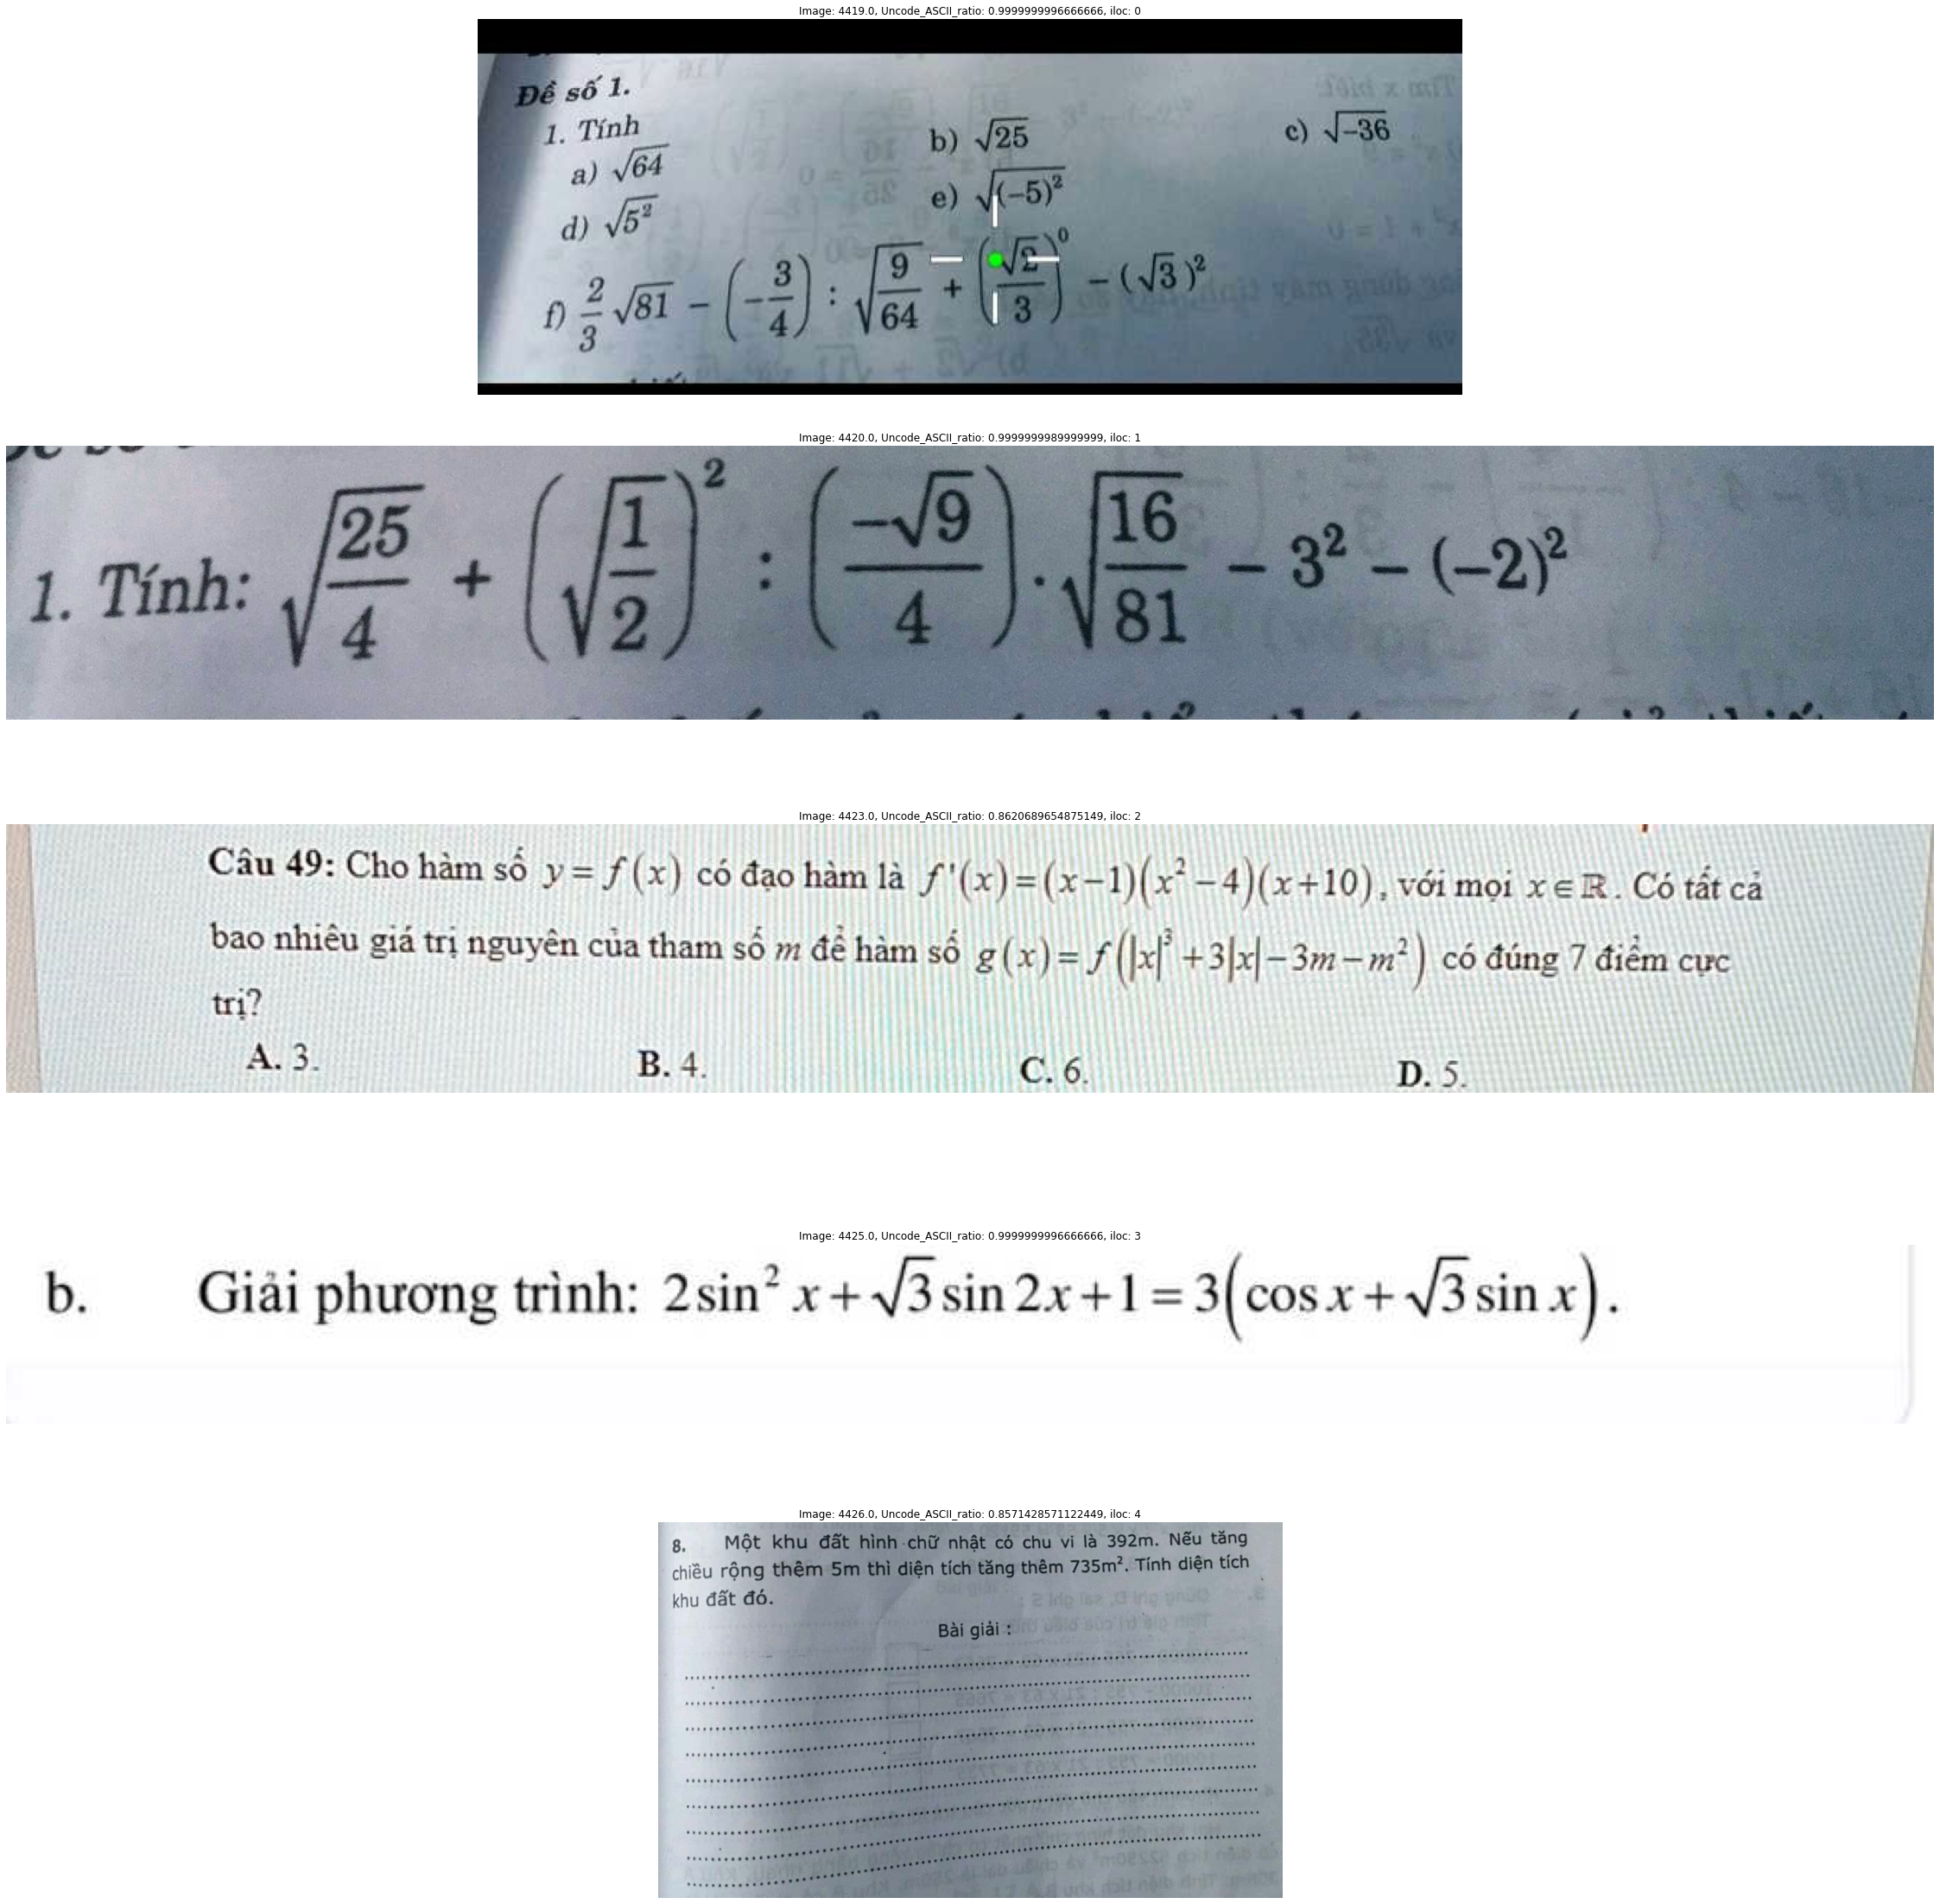

In [12]:
"""
    4475 4510
"""
test_case = test_batch
# test_case = data[data['Feedback ID']==4989]
display(i)
# test_case = test_m[test_m['final_scores'] < 0.9].iloc[0]
ImageList = []
NameList = []
for j in range(
    (i) * 5, 
    min((i+1) * 5, len(test_case))):
    test_img = test_case[
        ['Feedback ID', 'Lookup Image', 'Human Feedback', 'lookup_unicode_ascii_ratio']
    ].iloc[j]
    temp_1 = crawls_image(test_img['Lookup Image'], image_path, 'temp_1')
    ImageList.extend(
        [
            temp_1, 
        ]
    )
    NameList.extend(
        [
            'Image: {}, Uncode_ASCII_ratio: {}, iloc: {}'.format(
                test_img["Feedback ID"], test_img['lookup_unicode_ascii_ratio'], j
                )
        ]
    )

ShowImage(ImageList, NameList, len(ImageList), 1)
i = i + 1 if len(test_case) > 1 else 1

In [ ]:

k += 1

In [99]:
"""
    Summary
"""
fig = px.histogram(data, x=["lookup_kind", "question_kind"],barmode='group', text_auto=True)
fig.update_layout(title_text="Total number of each kind")
fig.show()

In [ ]:
"""
    Text n formula ratio
"""

fig = px.scatter(data, x='question_unicode_ascii_ratio', y='lookup_unicode_ascii_ratio', color='Human Feedback')
fig.update_layout(title_text="Ratio between Text and Formula")
fig.show()